# Import packages 

In [1]:
import csv
import os
from zipfile import ZipFile
from joblib import dump, load
import matplotlib  # Used to set default paremeters
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt, het_breuschpagan
from matplotlib import rcParams  # Used to set default parameters
from matplotlib.ticker import MaxNLocator
from scipy import stats
from scipy.spatial.distance import mahalanobis
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler,
)

# Figures default parameters 

In [2]:
sns.set_theme(style="darkgrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize


# Download data using Kaggle's API

In [3]:
# dataset_info = !kaggle datasets files adityadesai13/used-car-dataset-ford-and-mercedes
# if dataset_info[-1].split()[0] == "unclean":
#     dataset_name =  dataset_info[-1].split()[0] + " " + dataset_info[-1].split()[1]
# else:
#     dataset_name = dataset_name =  dataset_info[-1].split()[0]


path_data = os.getcwd() + "/data/UK used cars"
# path_zip = os.getcwd() + "/data/UK used cars/used-car-dataset-ford-and-mercedes.zip"
# path_file = os.getcwd() + "/data/UK used cars/" + dataset_name

# # if 
# if os.path.exists(path_data) == False:
#     os.mkdir(path_data)

# # if data is already downloaded, print a statement to remind me
# if os.path.exists(path_file):
#     print("Data has already been downloaded")
# # otherwise, download the data
# else:
#     # download data using kaggle API
#     !kaggle datasets download -d adityadesai13/used-car-dataset-ford-and-mercedes -p data/UK\ used\ cars/

#     # extract files in .zip folder
#     with ZipFile(path_zip) as zObject:
#         zObject.extractall(path=path_data)

#     # delete .zip folder
#     if os.path.exists(path_zip):
#         os.remove(path_zip)
#     else:
#         print(".zip file already deleted")

# EDA and Feature Engineering
## Data understanding

In [4]:
# list of files to load
files_to_load = ["audi.csv", "bmw.csv", "vw.csv"]

# empty list to store data
data_list = []

# loop through files in directory
for file in os.listdir(path_data):
    # check if file is in list of files to load
    if file in files_to_load:
        # open file and read data
        with open(os.path.join(path_data, file), newline='') as f:
            # create csv reader object
            reader = csv.reader(f)
            # iterate over rows in the csv file and add filename to each row
            reader_data = [row + [file.split(".")[0]] for row in reader]
            # store column names and data in data_list
            col_names = reader_data[0]
            data_list.append(reader_data[1:])

# concatenate data from all files into one dataframe
data = pd.concat(
    [
        pd.DataFrame(data_list[0]),
        pd.DataFrame(data_list[1]),
        pd.DataFrame(data_list[2])
    ]
).reset_index(drop=True)

# rename last column to "brand"
col_names[-1] = "brand"
data.columns = col_names

# print first five rows of data
data.head()


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,bmw
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,bmw
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,bmw
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,bmw
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,bmw


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36606 entries, 0 to 36605
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   model         36606 non-null  object
 1   year          36606 non-null  object
 2   price         36606 non-null  object
 3   transmission  36606 non-null  object
 4   mileage       36606 non-null  object
 5   fuelType      36606 non-null  object
 6   tax           36606 non-null  object
 7   mpg           36606 non-null  object
 8   engineSize    36606 non-null  object
 9   brand         36606 non-null  object
dtypes: object(10)
memory usage: 2.8+ MB


Having displayed the output of `pd.info()`, there are two things worth pointing out:
* There no missing values. The dataset was already cleaned by the author
* All the columns are `Object` type. This is something that hadn't happened to me before, so I assume it's due to reading the csv files using the `csv` library instead of using `pd.read_csv()`

In [6]:
int_cols = ["year", "price", "mileage", "tax"]
float_cols = ["mpg", "engineSize"]

data[int_cols] = data[int_cols].astype(int)
data[float_cols] = data[float_cols].astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36606 entries, 0 to 36605
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         36606 non-null  object 
 1   year          36606 non-null  int64  
 2   price         36606 non-null  int64  
 3   transmission  36606 non-null  object 
 4   mileage       36606 non-null  int64  
 5   fuelType      36606 non-null  object 
 6   tax           36606 non-null  int64  
 7   mpg           36606 non-null  float64
 8   engineSize    36606 non-null  float64
 9   brand         36606 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 2.8+ MB


In [7]:
# set the float format to display up to 3 decimal places
pd.options.display.float_format = '{:.2f}'.format

data.describe()

,year,price,mileage,tax,mpg,engineSize
count,36606.00,36606.00,36606.00,36606.00,36606.00,36606.00
mean,2017.16,20340.35,23892.27,122.19,53.66,1.86
std,2.18,10580.04,23124.06,64.54,20.49,0.58
min,1996.00,899.00,1.00,0.00,0.30,0.00
25%,2016.00,12990.00,5783.00,125.00,44.10,1.50
50%,2017.00,18489.00,17548.50,145.00,52.30,2.00
75%,2019.00,24991.00,34800.75,145.00,60.10,2.00
max,2020.00,145000.00,323000.00,580.00,470.80,6.60


## Data preparation
The first step in the data preparation process is to remove duplicates if they are present.

In [8]:
data.duplicated().value_counts()

False    36122
True       484
dtype: int64

As can be seen, `pd.duplicated` shows that there are 484 duplicated entries in the dataframe. Let's have a look at one of them:

In [9]:
data[data.duplicated(keep=False)].loc[(data["brand"] == "bmw") & (data["mileage"] == 7272)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
173,X4,2019,33998,Semi-Auto,7272,Diesel,150,42.80,2.00,bmw
174,X4,2019,33998,Semi-Auto,7272,Diesel,150,42.80,2.00,bmw


Given how accurate the mileage and the price is, I would say that the duplicated values are indeed two instances of the same car as opposed to two cars with the same features. Therefore, I will remove the duplicated values. 

In [10]:
data.drop_duplicates(ignore_index=True, inplace=True)
data.duplicated().value_counts()

False    36122
dtype: int64

Before going ahead, I will remove irrelevant features. In this data set, there aren't any irrelvant features per se, but there is one feature, `tax`, which applies to the UK and most likely won't be found in other data sets. My idea is to create a model that can be deployed and generalised, and this feature isn't part of that process.

In [11]:
data.drop(columns=["tax"], axis=1, inplace=True)

## Data encoding

In [12]:
data["transmission"].value_counts()

Manual       16058
Semi-Auto    11900
Automatic     8164
Name: transmission, dtype: int64

In [13]:
data["fuelType"].value_counts()

Diesel      18776
Petrol      16754
Hybrid        467
Other         122
Electric        3
Name: fuelType, dtype: int64

In [14]:
mask = (data["fuelType"] == "Other") | (data["fuelType"] == "Electric")
data = data[~mask].reset_index(drop=True)

In [15]:
# Create one hot encoder transformer
transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), ["transmission", "fuelType"]),
    remainder="drop",
)

# Transform data and create dataframe with the new data
transformed = transformer.fit_transform(data)
data_transformed = pd.DataFrame(
    transformed, columns=transformer.get_feature_names_out()
)

# Change column types to integer
data_transformed = data_transformed.astype(int)

# Modify new column name to remove "onehotencoder__" from it
new_ohe_col_names = [
    column.replace("onehotencoder__", "")
    for column in transformer.get_feature_names_out().tolist()
]

# Rename columns of the new dataframe
data_transformed.columns = new_ohe_col_names

# Drop original features in the original dataframe and add the one-hot-encoded columns
data.drop(["transmission", "fuelType"], axis=1, inplace=True)
data = pd.concat([data, data_transformed], axis=1)

data.head()

,model,year,price,mileage,mpg,engineSize,brand,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Petrol
0,5 Series,2014,11200,67068,57.60,2.00,bmw,0,0,0,0
1,6 Series,2018,27000,14827,42.80,2.00,bmw,0,0,0,1
2,5 Series,2016,16000,62794,51.40,3.00,bmw,0,0,0,0
3,1 Series,2017,12750,26676,72.40,1.50,bmw,0,0,0,0
4,7 Series,2014,14500,39554,50.40,3.00,bmw,0,0,0,0


## Feature understanding and outliers

In this section, I will explore features individually to identify and remove outliers and understand if some features need any scaling (recall the the goal is to build a linear regression model and linear regression gets along really well with normally distributed features)

/var/folders/87/0c9vcs_11172l6932m_lk5x40000gn/T/ipykernel_36038/3495036086.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(layout=(3,4),bins=25, ax=ax);


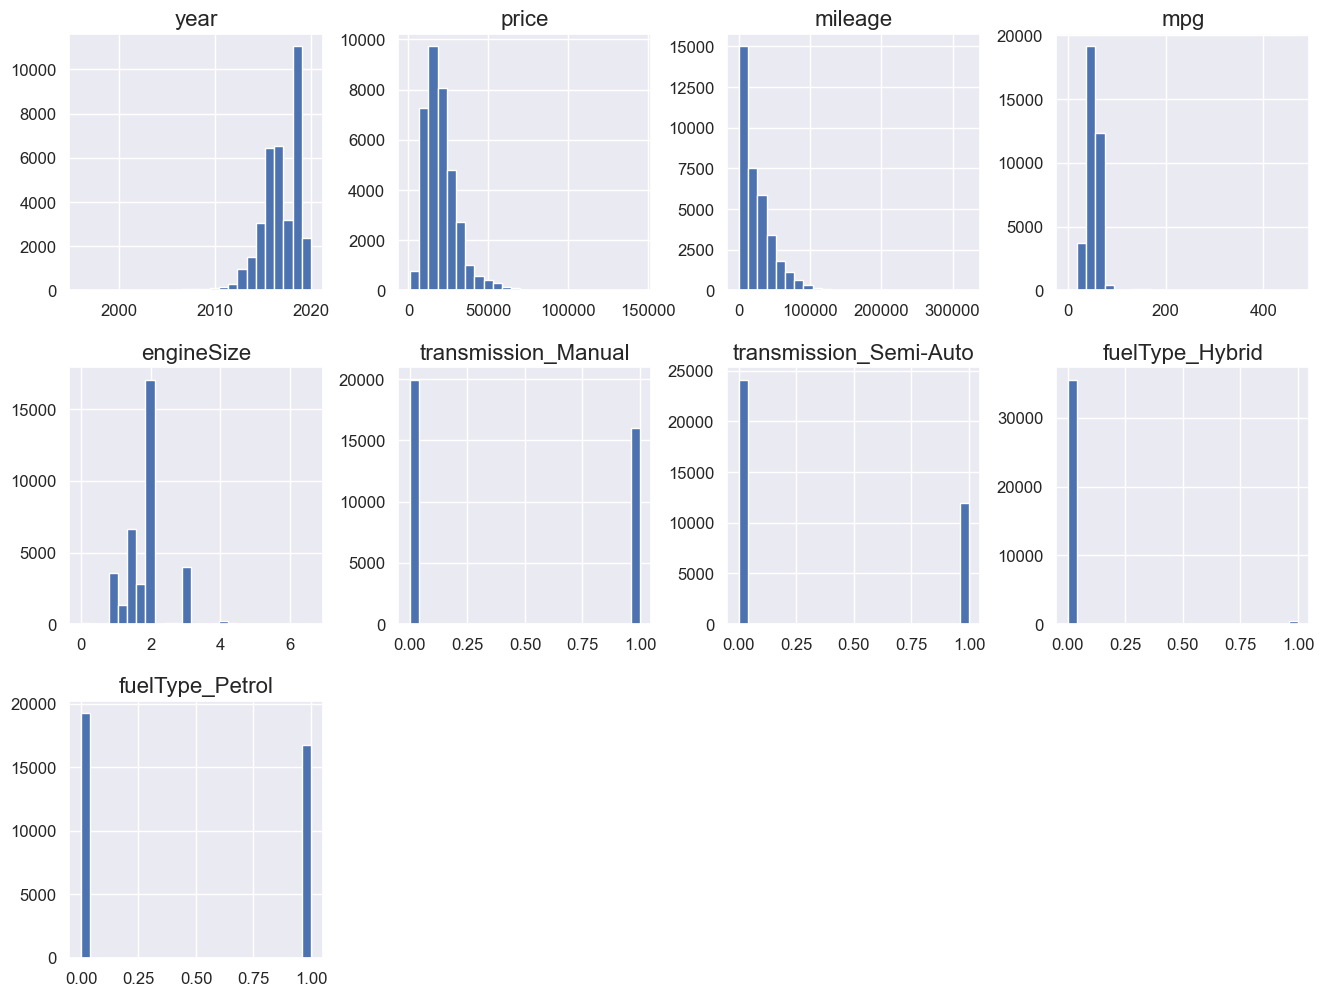

In [16]:
fig, ax = plt.subplots(figsize=(16,12))
data.hist(layout=(3,4),bins=25, ax=ax);

In the image above, we can see that some features show the presence of outliers, such as mpg, and others could do with a log transformation, such as the price or the mileage.

The one-hot-encoded features don't need especial attention since I already checked them before, although it's worth noting the unbalanced distribution of hybrid vehicles.

Let's analyse some of these features individually.


### Year


<AxesSubplot: xlabel='year', ylabel='brand'>

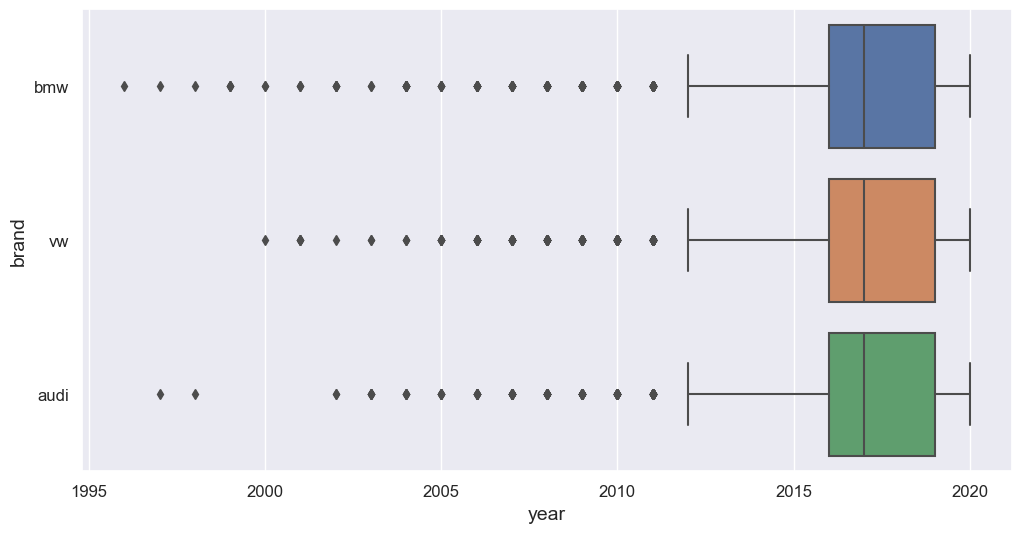

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="year", y="brand", data=data, ax=ax)

According to this box plot, most the years could be considered outliers and they wouldn't be part of the model. Instead, I will have a look at the number of cars by year in ascending order:

In [18]:
data_year = data.groupby(["year", "brand"]).size().unstack()
data_year["total"] = data_year[["audi", "bmw", "vw"]].sum(axis=1)
data_year.iloc[:12]

brand,audi,bmw,vw,total
year,,,,
1996,NaN,1.00,NaN,1.00
1997,1.00,1.00,NaN,2.00
1998,1.00,1.00,NaN,2.00
1999,NaN,4.00,NaN,4.00
2000,NaN,2.00,1.00,3.00
2001,NaN,3.00,4.00,7.00
2002,2.00,6.00,1.00,9.00
2003,6.00,2.00,2.00,10.00
2004,5.00,12.00,3.00,20.00


It makes sense to remove the years in which the number of cars is less than 20 and the number of cars per brand is less than 5, which means that cars manufactured before 2005 will be removed. This are arbitrary numbers, but the best way forward is to try this strategy first and develop a new one if the model underperforms.

### Price

<AxesSubplot: xlabel='price', ylabel='brand'>

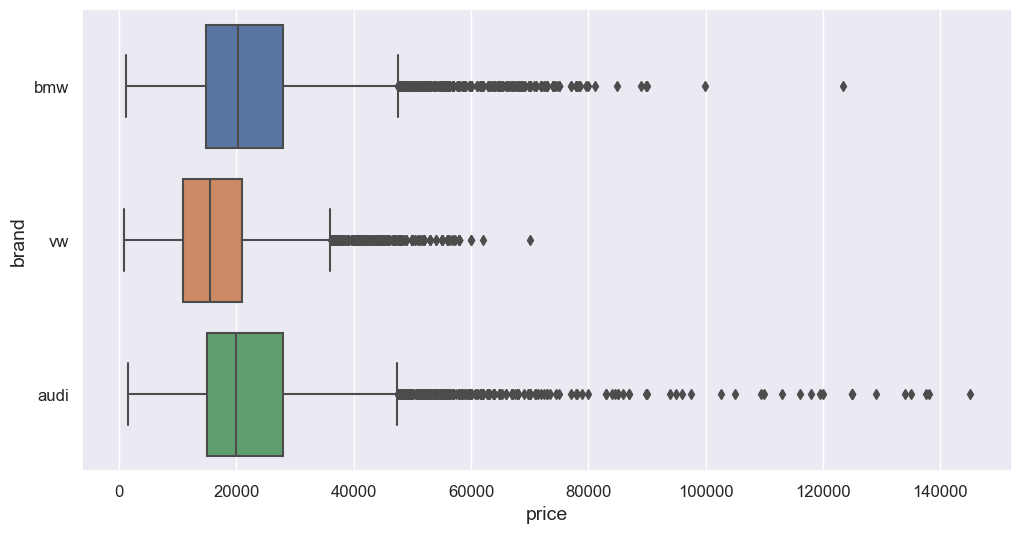

In [19]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="price", y="brand", data=data, ax=ax)

<AxesSubplot: xlabel='price', ylabel='Count'>

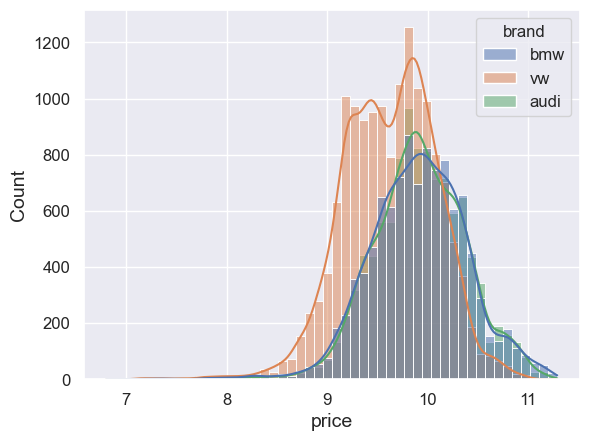

In [20]:
mask_audi = (data["brand"] == "audi") & (data["price"] < 75000)
mask_vw = (data["brand"] == "vw") & (data["price"] < 60000)
mask_bmw = (data["brand"] == "bmw") & (data["price"] < 80000)
mask_brand = mask_audi | mask_vw | mask_bmw
data_brand = data[mask_brand]

fig, ax = plt.subplots()
sns.histplot(x=np.log(data_brand["price"]), bins=50, hue="brand",kde=True, data=data_brand)

### Mileage

<AxesSubplot: xlabel='mileage', ylabel='brand'>

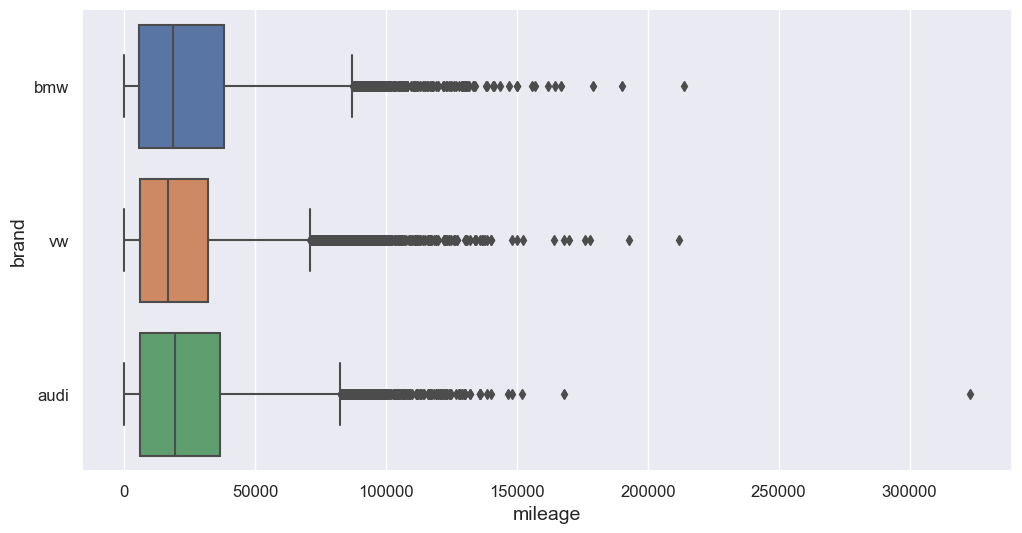

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="mileage", y="brand", data=data)

### MPG

<AxesSubplot: xlabel='mpg', ylabel='brand'>

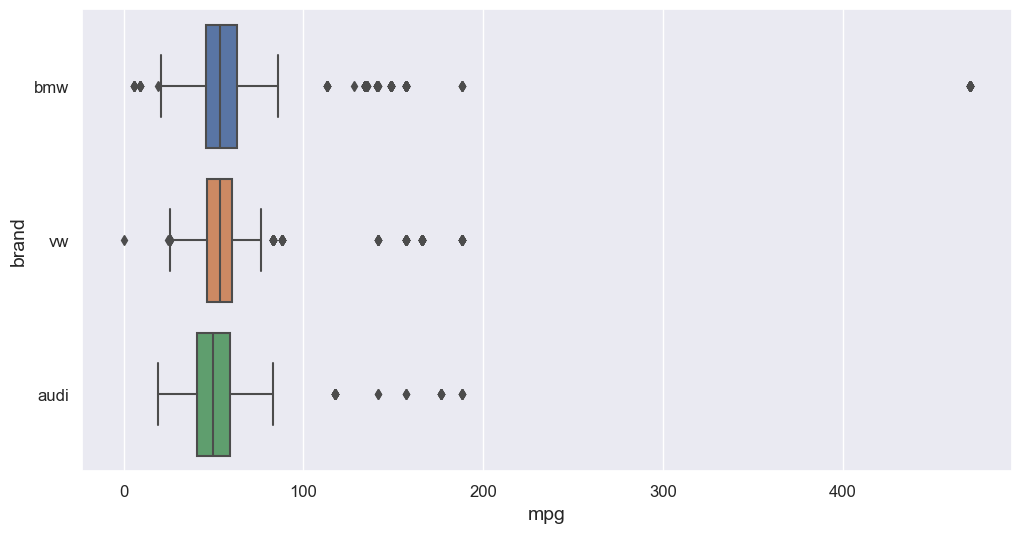

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="mpg", y="brand", data=data)

In [23]:
more_than_100 = len(data.loc[data["mpg"] > 100])
more_than_100_hybrid = len(data.loc[(data["mpg"] > 100) & (data["fuelType_Hybrid"] == 1)])
print(f" Number of cars with mpg > 100: {more_than_100}")
print(f" Number of cars with mpg > 100 and hybrid: {more_than_100_hybrid}")

 Number of cars with mpg > 100: 344
 Number of cars with mpg > 100 and hybrid: 338


As can be seen, most of the cars whose miles per gallon exceed 100 are in fact hybrid cars. While they would classify as outliers compared with the other values, I won't remove them since I want the model to deal with hybrid cars.

What about the other end of the spectrum?

In [24]:
data[(data["mpg"] < 18)].sample(5, random_state=43)

,model,year,price,mileage,mpg,engineSize,brand,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Petrol
6373,3 Series,2019,35995,2166,8.80,2.00,bmw,0,1,1,0
6057,X3,2020,42990,3245,5.50,2.00,bmw,0,1,1,0
6849,X3,2020,52991,4360,5.50,2.00,bmw,0,1,1,0
24780,Golf SV,2019,17950,100,0.30,1.00,vw,1,0,0,1
3060,3 Series,2019,35230,4602,8.80,2.00,bmw,0,1,1,0


I checked on Google and neither of those models have such low `mpg` values. I will then remove those cars whose `mpg` is less than 18.

### Engine size

<AxesSubplot: xlabel='engineSize', ylabel='brand'>

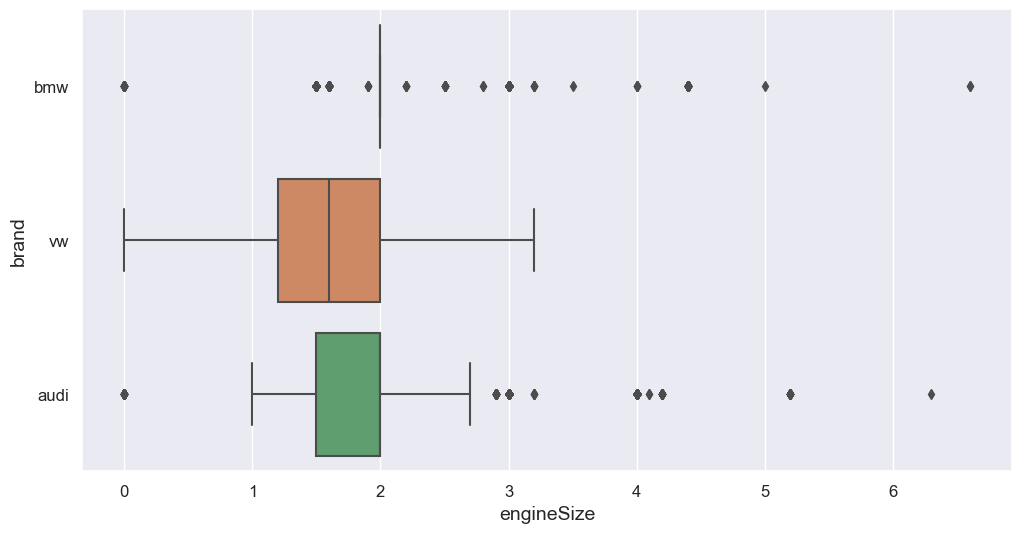

In [25]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x="engineSize", y="brand", data=data)

In [26]:
data[data["engineSize"] > 4.5].sample(7, random_state=44)

,model,year,price,mileage,mpg,engineSize,brand,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Petrol
29587,R8,2019,137500,10,21.40,5.20,audi,0,1,0,1
29796,R8,2018,93950,3800,23.00,5.20,audi,0,1,0,1
9666,7 Series,2017,57000,11297,22.10,6.60,bmw,0,0,0,1
32481,R8,2019,119450,3000,21.40,5.20,audi,0,0,0,1
35401,R8,2016,74500,28888,24.10,5.20,audi,0,0,0,1
35479,A6,2006,8750,98000,21.10,5.20,audi,0,0,0,1
33033,R8,2014,58450,35000,21.90,5.20,audi,0,0,0,1


Similarly to the previous features, I need to choose a threshold to determine what qualifies as an outlier. I think that cars with an engine size larger than 5.2 L have to removed. The reality is that most of those cars also exceed the price threshold defined in a previous section.

It's now time to remove all the outliers defined in the previous sections:

In [27]:
shape_before_outliers = data.shape
# Remove outliers based on "year" feature
data = data[data["year"] > 2005].reset_index(drop=True)

# Remove outliers based on "price" feature
mask_audi = (data["brand"] == "audi") & (data["price"] < 75000)
mask_vw = (data["brand"] == "vw") & (data["price"] < 60000)
mask_bmw = (data["brand"] == "bmw") & (data["price"] < 100000)
mask_brand = mask_audi | mask_vw | mask_bmw
data = data[mask_brand].reset_index(drop=True)

# Remove outliers based on "mileage" feature
data = data[data["mileage"] < 150000].reset_index(drop=True)

# Remove outliers based on "MPG" feature
data = data[(data["mpg"] > 18) & (data["mpg"] < 200)].reset_index(drop=True)

# Remove outliers based on "engineSize" feature
data = data[(data["engineSize"] > 1) & (data["engineSize"] < 5.2)].reset_index(drop=True)
shape_after_outliers = data.shape


In [28]:
data["price"] = np.log(data["price"])
data["mileage"] = np.log(data["mileage"])

## Multivariate outlier detection

Something I found in the first runs of this notebook is that worst performing points after creating the regression models aren't "traditional outliers". Since I already went through outlier detection and removal of individual features, these datapoints aren't outliers in a single category, but it's the combination of values, such as a very high kilometer value. yet a very expensive car, that causes the model to underperform. 

As a result, I've implemented the Mahalanobis distance to find multivarite outliers:

In [29]:
data_mahal = data.drop(columns=["model", "brand"], axis=1)

ss = StandardScaler()
data_mahal_scaled = pd.DataFrame(ss.fit_transform(data_mahal))
data_mahal_scaled.columns = ss.get_feature_names_out().tolist()
data_mahal_scaled.head()


,year,price,mileage,mpg,engineSize,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Petrol
0,-1.48,-1.11,1.00,0.31,0.07,-0.81,-0.75,-0.11,-0.83
1,0.42,0.76,0.12,-0.68,0.07,-0.81,-0.75,-0.11,1.21
2,-0.53,-0.36,0.96,-0.10,2.02,-0.81,-0.75,-0.11,-0.83
3,-0.05,-0.84,0.46,1.31,-0.91,-0.81,-0.75,-0.11,-0.83
4,-1.48,-0.57,0.69,-0.17,2.02,-0.81,-0.75,-0.11,-0.83


In [30]:
cov = data_mahal_scaled.cov()
mu = data_mahal_scaled.mean()


# Calculate the inverse of the covariance matrix
cov_inv = np.linalg.inv(cov)

# Calculate the Mahalanobis distance for each observation
distances = [
    mahalanobis(data_mahal_scaled.iloc[i, :], mu, cov_inv) for i in range(len(data_mahal_scaled))
]

# Set a threshold for the distances
threshold = np.percentile(distances, 95)

# Identify the outliers
outliers = [i for i in range(len(data_mahal_scaled)) if distances[i] > threshold]

# data = data.drop(outliers, axis=0).reset_index(drop=True)

In [31]:
data_mahal_outliers = data.loc[outliers]
data_mahal_outliers["price"] = np.exp(data_mahal_outliers["price"])
data_mahal_outliers["mileage"] = np.exp(data_mahal_outliers["mileage"])
data_mahal_outliers.sample(7, random_state=42)

,model,year,price,mileage,mpg,engineSize,brand,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Petrol
896,M5,2019,62898.00,4200.00,26.90,4.40,bmw,0,1,0,1
2216,Z4,2020,28990.00,5.00,38.20,2.00,bmw,0,1,0,1
8985,6 Series,2006,4999.00,126054.00,29.70,3.00,bmw,0,0,0,1
26256,Q5,2019,44495.00,8700.00,117.70,2.00,audi,0,1,1,0
2625,5 Series,2020,32475.00,12.00,49.60,2.00,bmw,0,1,1,0
13242,Golf,2018,23250.00,23471.00,156.90,1.40,vw,0,1,1,0
17844,Polo,2010,4999.00,37989.00,47.90,1.40,vw,0,0,0,1


In [32]:
data.loc[(outliers) and (data["fuelType_Hybrid"] == 1)].shape

(419, 11)

Unfortunately, all the hybrid cars are identified as multivariate outliers. Again, my initial approach is to include them in the model and if it doesn't perform well I will remove them.

Having removed the univariate outliers, let's have a look at how many data points have been removed:

In [33]:
num_outliers = shape_before_outliers[0] - shape_after_outliers[0]
pctg_outliers = num_outliers / shape_before_outliers[0] * 100
print(f"Number of data points before removing outliers: {shape_before_outliers[0]}")
print(f"Number of data points after removing outliers: {shape_after_outliers[0]}")
print(f"Number of outliers removed: {num_outliers}, which represents {pctg_outliers:.1f}% of the original data set")

Number of data points before removing outliers: 35997
Number of data points after removing outliers: 32150
Number of outliers removed: 3847, which represents 10.7% of the original data set


## Feature Relationships

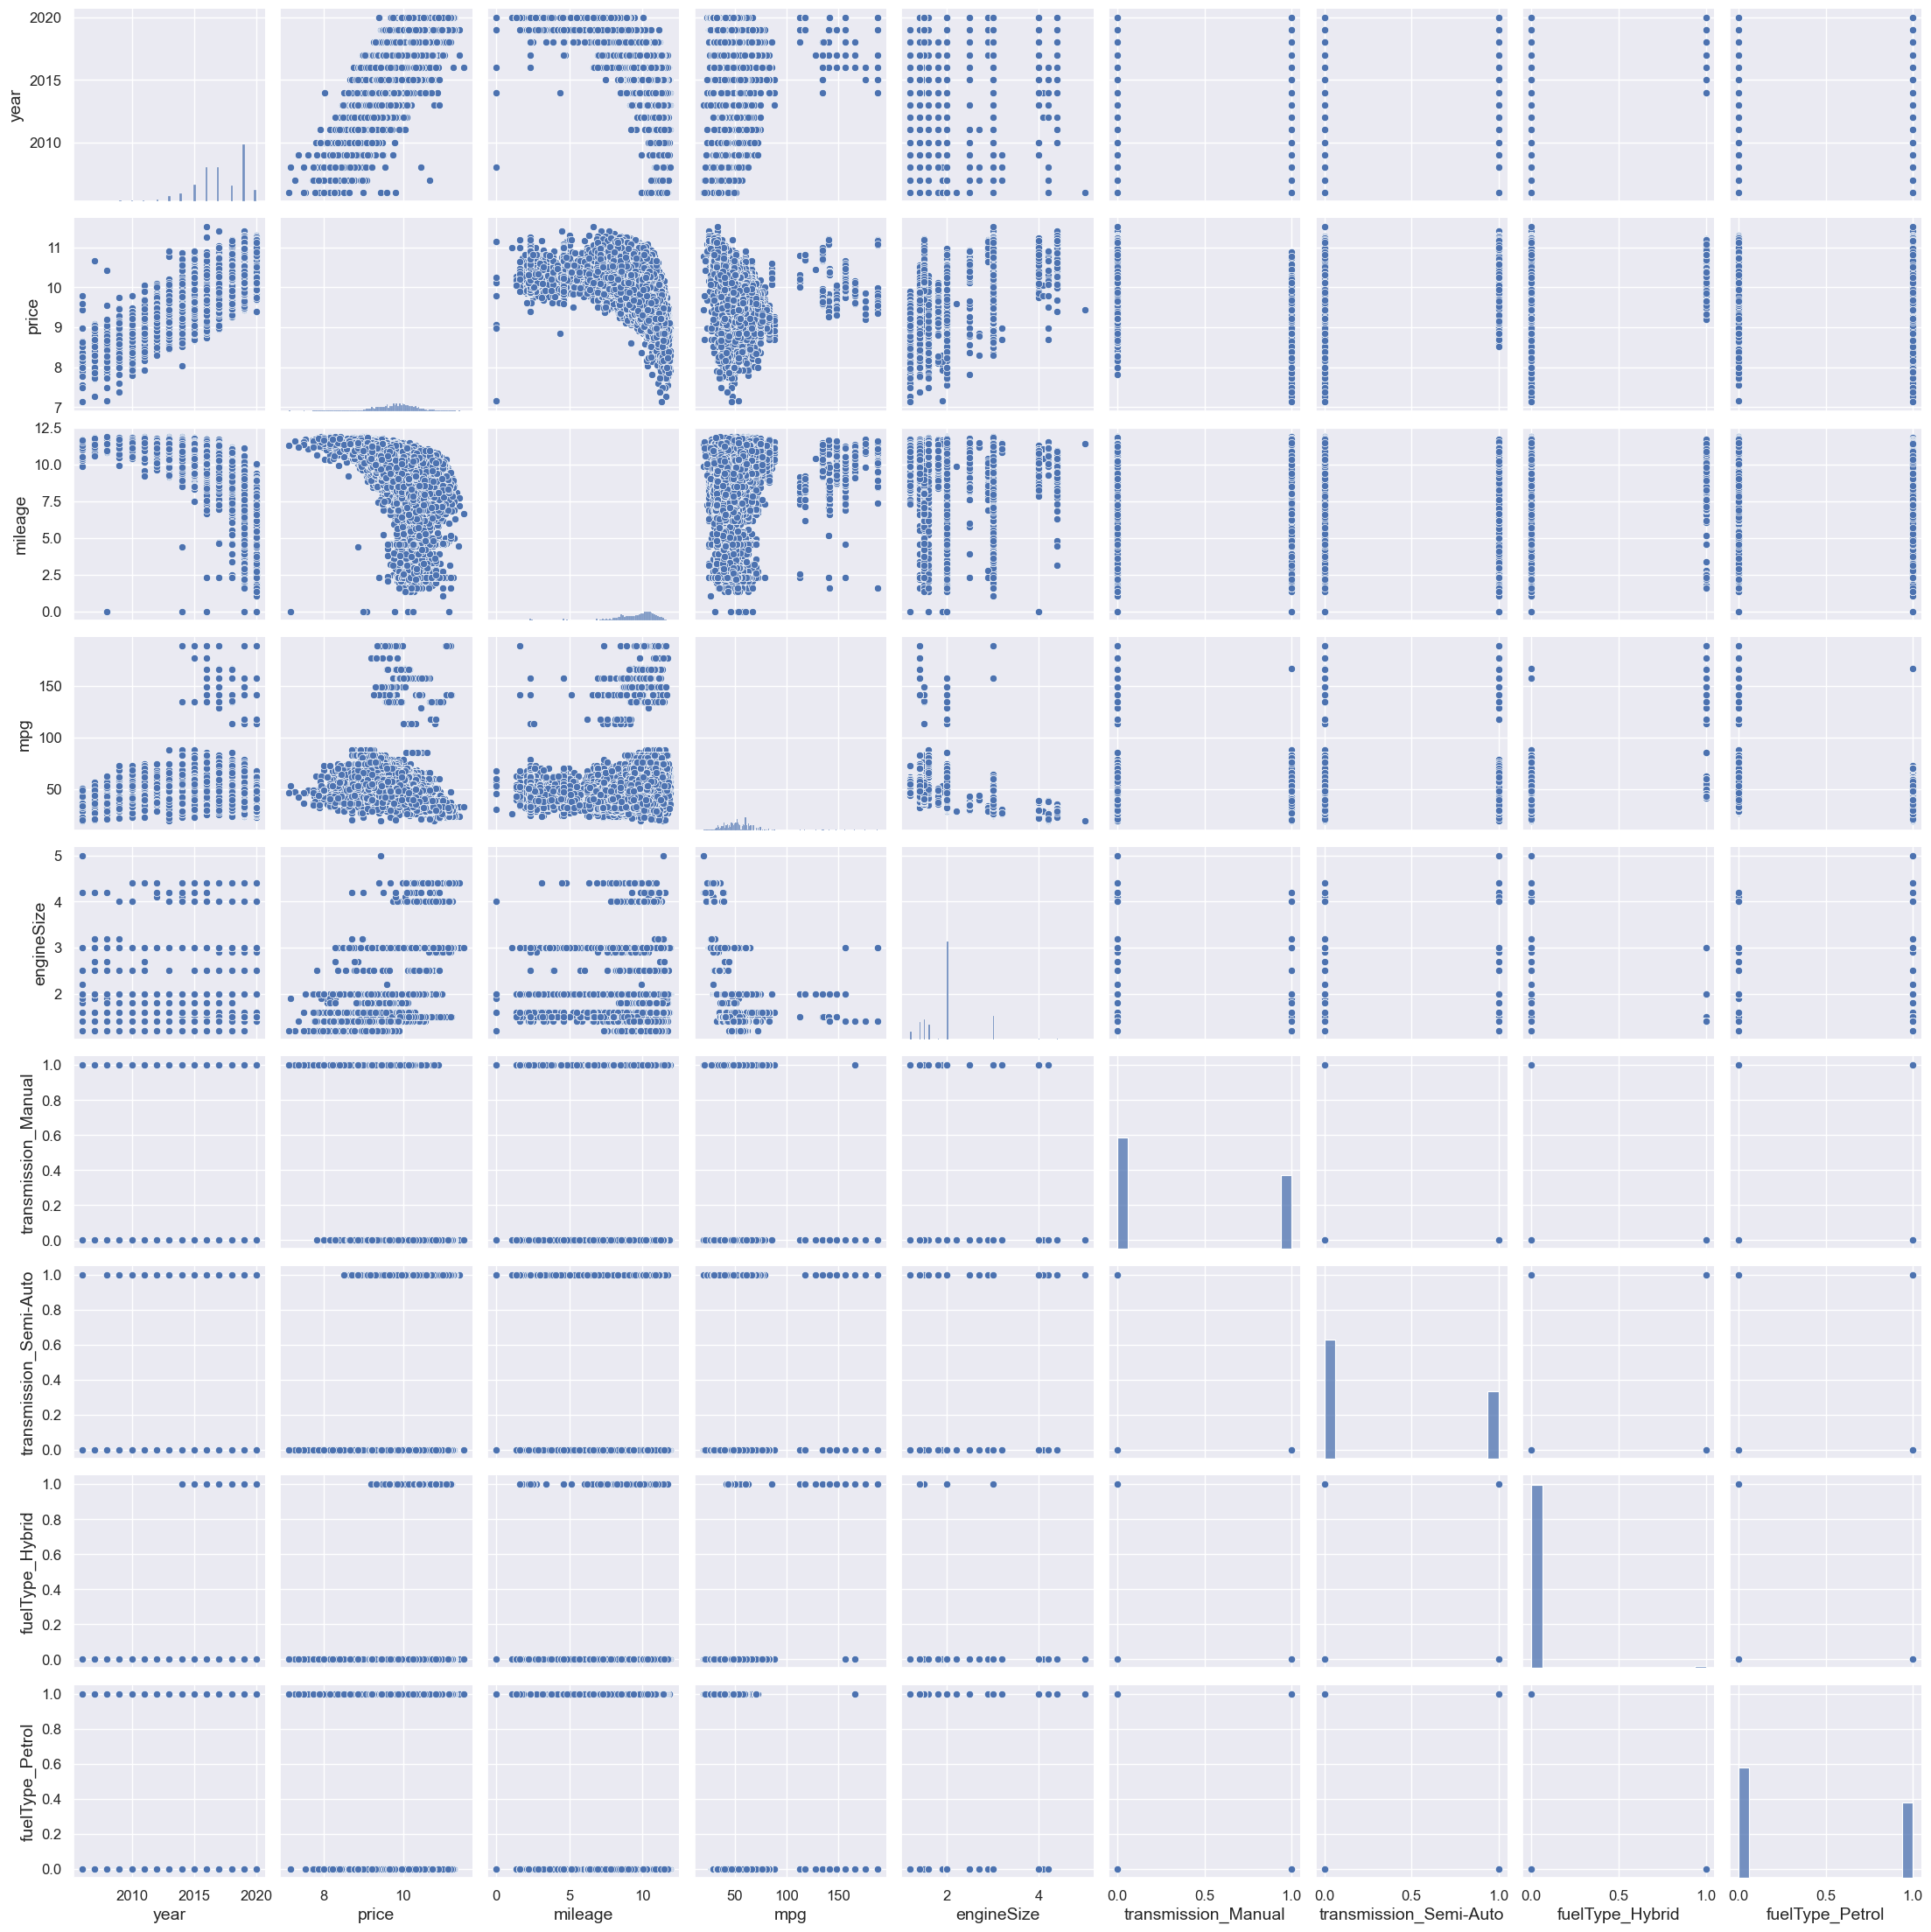

In [34]:
sns.pairplot(data=data)

/var/folders/87/0c9vcs_11172l6932m_lk5x40000gn/T/ipykernel_36038/310756154.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt=".2f");


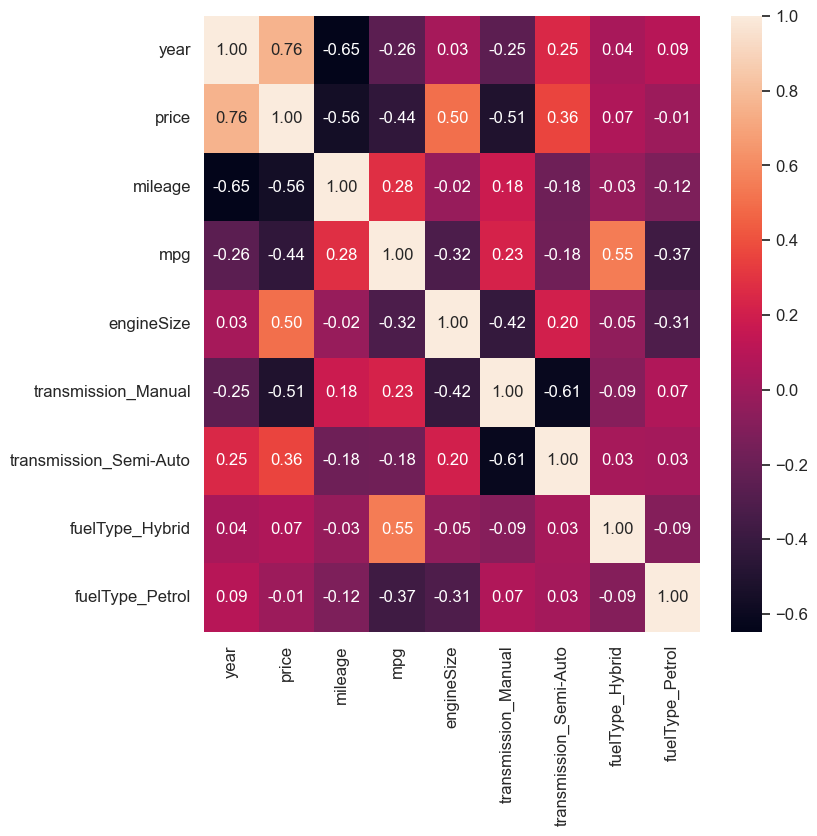

In [35]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f");

/var/folders/87/0c9vcs_11172l6932m_lk5x40000gn/T/ipykernel_36038/391960434.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = data_brand.corr()["price"].sort_values()[:-1]
/var/folders/87/0c9vcs_11172l6932m_lk5x40000gn/T/ipykernel_36038/391960434.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = data_brand.corr()["price"].sort_values()[:-1]
/var/folders/87/0c9vcs_11172l6932m_lk5x40000gn/T/ipykernel_36038/391960434.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this

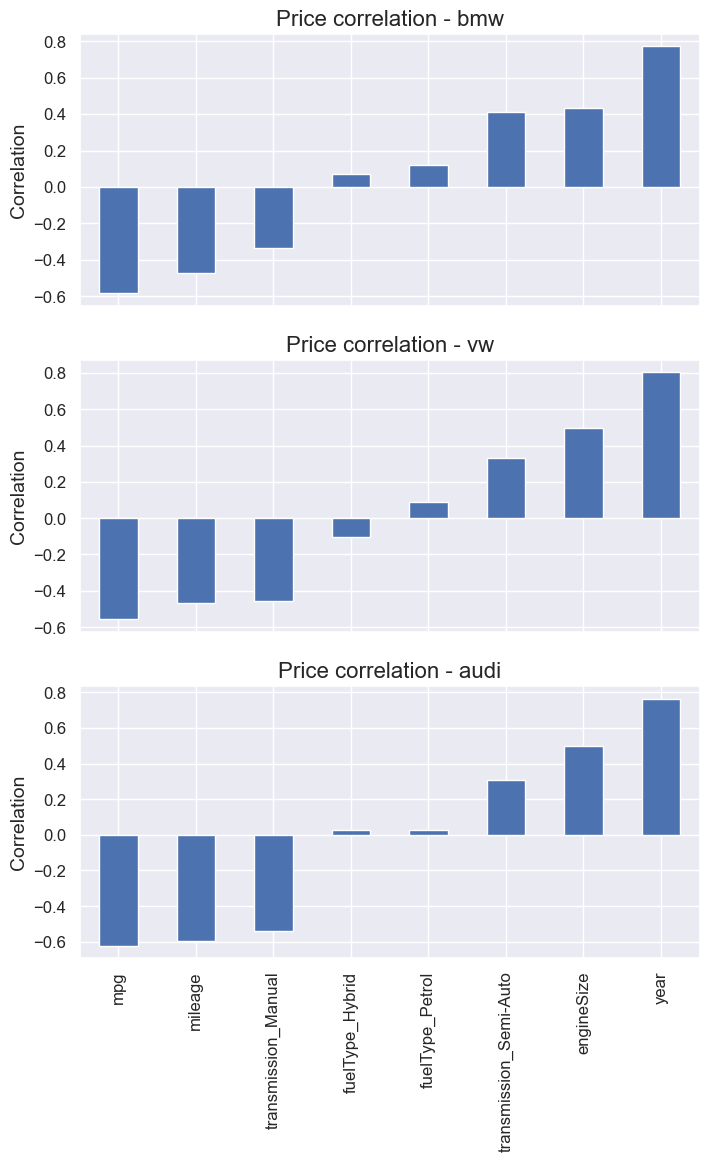

In [36]:
brands = data["brand"].unique().tolist()

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
axes = axes.flatten()

for i, brand in enumerate(brands):
    data_brand = data[data["brand"] == brand]
    corr_df = data_brand.corr()["price"].sort_values()[:-1]
    corr_df.plot(
        kind="bar",
        ax=axes[i],
        title=f"Price correlation - {brand}",
        ylabel="Correlation",
    )

# Regression - difference between brands

In [37]:
def plot_residuals_analysis(X_test, y_test, model, is_nn = None):
    """_summary_

    Parameters
    ----------
    X_test : _type_
        _description_
    y_test : _type_
        _description_
    model : _type_
        _description_
    is_nn : _type_, optional
        _description_, by default None
    """
    # Generate predictions and residuals
    predictions = model.predict(X_test)
    if is_nn:
        predictions = predictions.reshape(-1)
    residuals = y_test - predictions
    
    # Calculate min and max values for plot
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())

    # Print RMSE of residuals
    print(f"RMSE of residuals: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}")

    # Test for homocedasticity
    # Use het_breuschpagan to test for heteroscedasticity
    lm, p, fvalue, fpvalue = het_breuschpagan(residuals, X_test)
    # Print results
    print("----HETEROCEDASTICITY----")
    print(f"Breusch-Pagan test: p-value={p:.3f}, f-value={fvalue:.2f}, fp-value={fpvalue:.3f}")
    
    # Use het_goldfeldquandt to test for heterocedasticity
    test_stat, p_value, _ = het_goldfeldquandt(residuals, X_test)
    # Print results
    print(f"Goldfeld-Quandt test: p-value={p_value:.3f}, test stat={test_stat:.2f}")

    # Test for normality using kstest
    test_stat, p_value = stats.kstest(residuals, "norm")
    # Print results
    print("----NORMALITY----")
    print(f"Skewness of residuals: {stats.skew(residuals)}")
    print(f"Kurtosis of residuals: {stats.kurtosis(residuals)}")
    print(f"Kolmogorov-Smirnov test: p-value={p_value:.3f}, test stat={test_stat:.2f}")

    # Plot results using subplots
    fig, axes = plt.subplots(1, 4, figsize=(21, 6))

    # Plot true values vs. predictions using scatterplot
    sns.scatterplot(x=y_test, y=predictions, ax=axes[0], alpha=0.25)
    axes[0].set_title("True values vs predictions")
    # Add line to indicate perfect prediction
    axes[0].plot([min_val, max_val], [min_val, max_val], c="r", lw=3)
    axes[0].set_xlabel("True values")
    axes[0].set_ylabel("Predictions")

    # Plot residuals using scatterplot
    sns.scatterplot(x=y_test, y=residuals, ax=axes[1], alpha=0.25)
    axes[1].set_title("Residuals")
    # Add line to indicate zero residual
    axes[1].plot([y_test.min(), y_test.max()], [0, 0], c="r", lw=3)
    axes[1].set_xlabel("True values")
    axes[1].set_ylabel("Residuals")

    # Plot QQ plot to test for normality
    qqplot(residuals, fit=True, line="45", ax=axes[2])
    axes[2].set_title("QQ plot")
    # Generate a normal distribution using mean and std from residuals
    mean = np.mean(residuals)
    std = np.std(residuals)
    norm_dist = stats.norm(loc=mean, scale=std)
    x_vals = np.linspace(mean - 4 * std, mean + 4 * std, 1000)
    # Calculate multiplier to overlay normal dsitribution on top of residual histogram
    counts, _ = np.histogram(residuals, bins=50)
    multiplier = max(counts) / max(norm_dist.pdf(x_vals))

    # Plot histogram of residuals
    sns.histplot(x=residuals, ax=axes[3], bins=50, kde=True)
    # Plot normal distribution on top of histogram
    axes[3].plot(x_vals, norm_dist.pdf(x_vals) * multiplier, color="red")
    axes[3].set_title("Histogram of residuals")
    axes[3].set_xlabel("Residuals")


In [38]:
TARGET = "price"
FEATURES = [
    column for column in data.columns if data[column].dtype != "O" and column != TARGET
]

X_data = data[FEATURES]
y_data = data[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42, shuffle=True, stratify=X_data["fuelType_Hybrid"]
)

train_idx = X_train.index
test_idx = X_test.index


RMSE of residuals: 0.15
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=293.40, fp-value=0.000
Goldfeld-Quandt test: p-value=0.168, test stat=1.03
----NORMALITY----
Skewness of residuals: 0.09419983892233667
Kurtosis of residuals: 1.7305226719136568
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.36


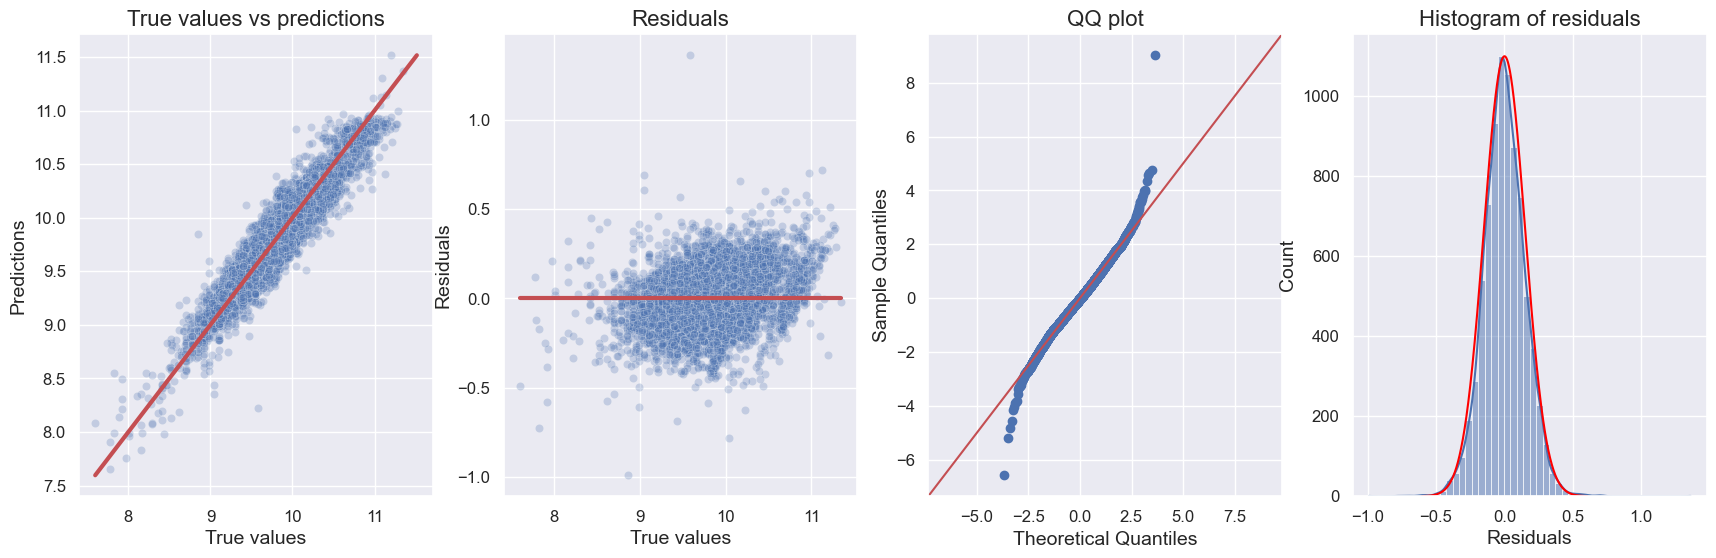

In [39]:
num_splits = 5
sk_fold = StratifiedKFold(n_splits=num_splits, random_state=42, shuffle=True)
folds = sk_fold.split(X_train, X_train["fuelType_Hybrid"])

# Define pipeline steps
steps = [
    ("scaler", MinMaxScaler()),
    ("pol_features", PolynomialFeatures()),
    ("model", LinearRegression()),
]

# Create pipeline object
pipeline = Pipeline(steps=steps)

param_grid = {"pol_features__degree": range(1, 6)}

search_lr = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=["neg_root_mean_squared_error", "r2"],
    refit="neg_root_mean_squared_error",
    cv=folds,
    n_jobs=-1,
    verbose=0,
)

search_lr.fit(X_train, y_train);

plot_residuals_analysis(X_test, y_test, search_lr)

RMSE of residuals: 0.15
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=122.85, fp-value=0.000
Goldfeld-Quandt test: p-value=0.424, test stat=1.01
----NORMALITY----
Skewness of residuals: 0.1974084097328487
Kurtosis of residuals: 0.9022048300828542
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.37
RMSE of residuals: 0.15
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=88.93, fp-value=0.000
Goldfeld-Quandt test: p-value=0.926, test stat=0.93
----NORMALITY----
Skewness of residuals: 0.2969957392323193
Kurtosis of residuals: 4.902573723626953
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.39
RMSE of residuals: 0.15
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=139.97, fp-value=0.000
Goldfeld-Quandt test: p-value=0.005, test stat=1.16
----NORMALITY----
Skewness of residuals: -0.19864413052045873
Kurtosis of residuals: 1.8151052289107525
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.40


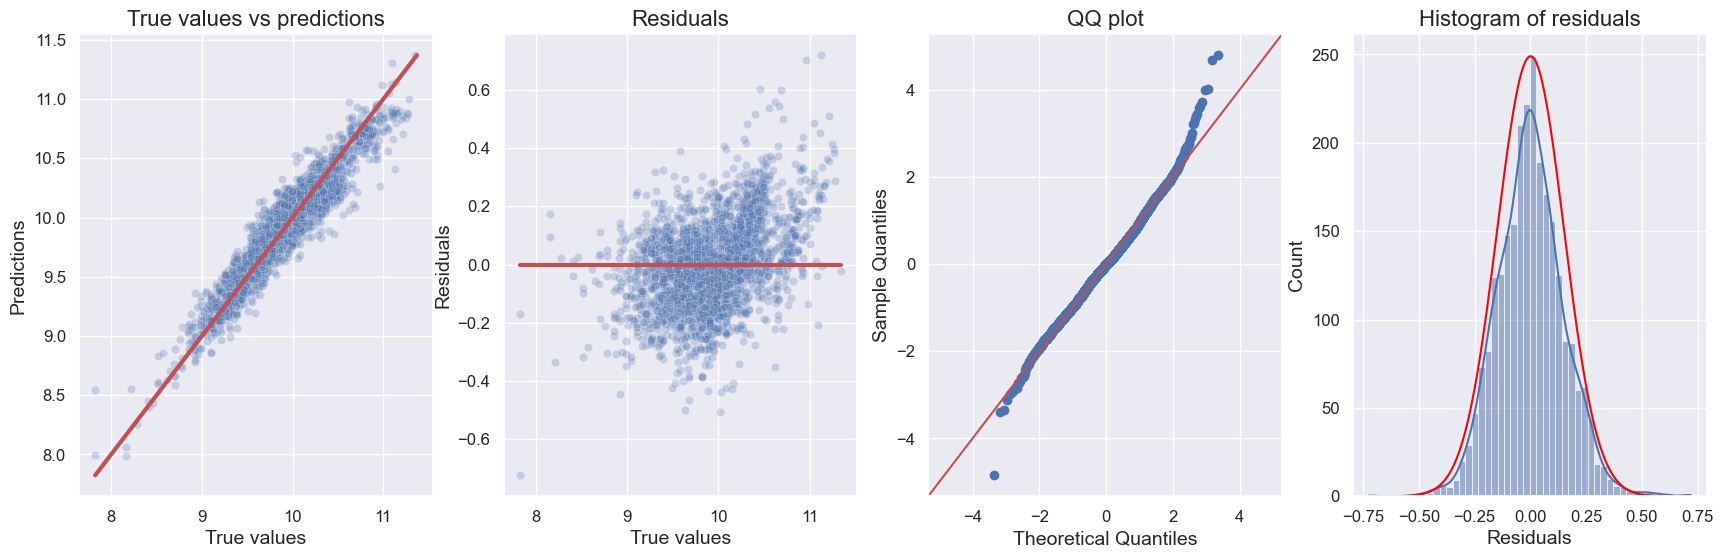

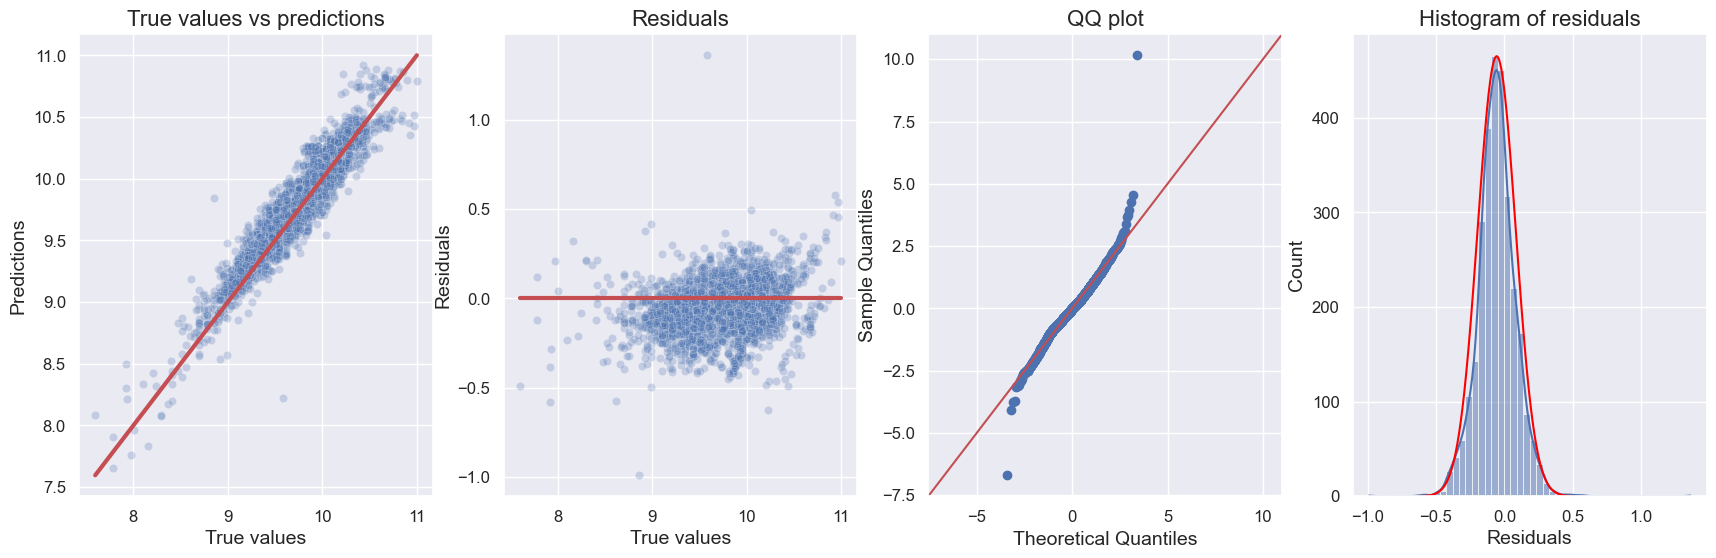

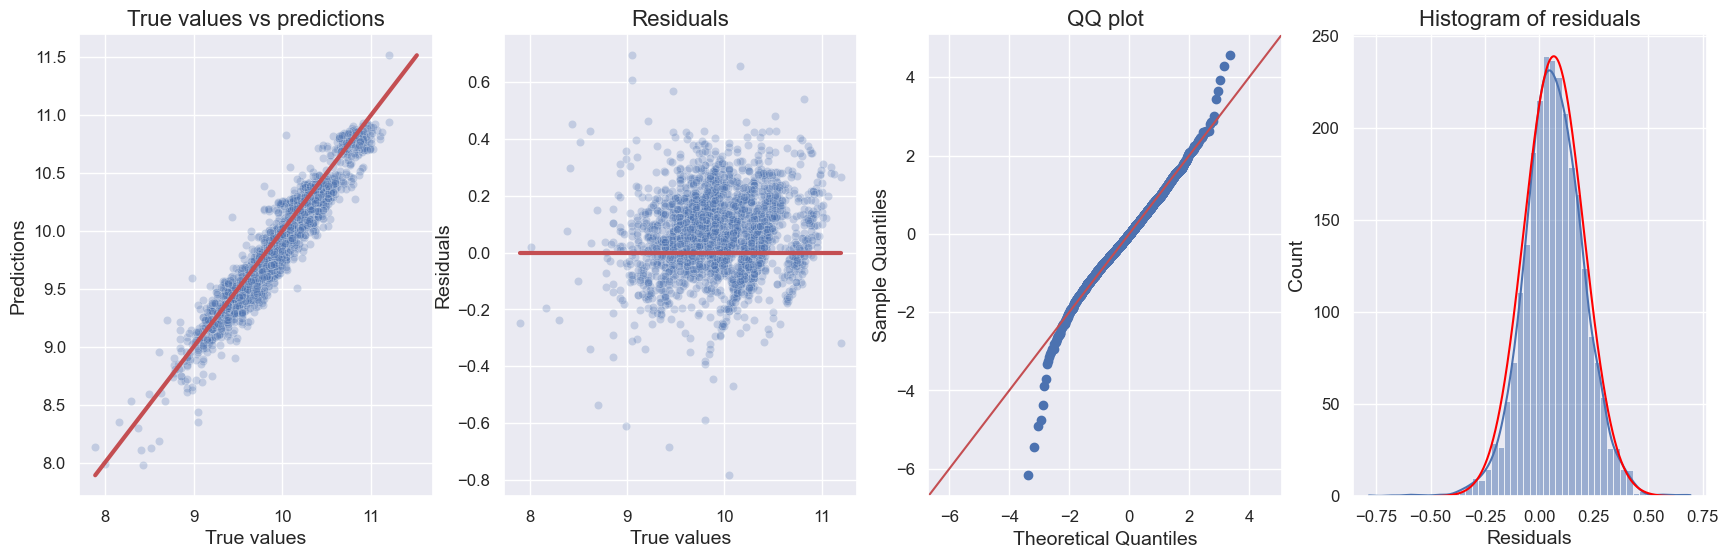

In [40]:
brands = data["brand"].unique().tolist()
data_test = data.loc[X_test.index]

for i, brand in enumerate(brands):
    data_brand = data_test[data_test["brand"] == brand]

    X_test_brand = data_brand[FEATURES]
    y_test_brand = data_brand[TARGET]

    plot_residuals_analysis(X_test_brand, y_test_brand, search_lr)

In [41]:
# num_splits = 5
# sk_fold = StratifiedKFold(n_splits=num_splits, random_state=42, shuffle=True)
# folds = sk_fold.split(X_train, X_train["fuelType_Hybrid"])

# # Define pipeline steps
# steps = [
#     ("scaler", MinMaxScaler()),
#     # ("pol_features", PolynomialFeatures()),
#     ("model", xgb.XGBRegressor()),
# ]

# # Create pipeline object
# pipeline = Pipeline(steps=steps)

# # param_grid = {"pol_features__degree": range(1, 3)}
# param_grid = {"model__n_estimators": [50, 100, 200], "model__max_depth": [3, 6]}

# search_xgb = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring=["neg_root_mean_squared_error", "r2"],
#     refit="neg_root_mean_squared_error",
#     cv=folds,
#     n_jobs=-1,
#     verbose=3,
# )

# search_xgb.fit(X_train, y_train);

# plot_residuals_analysis(X_test, y_test, search_xgb)

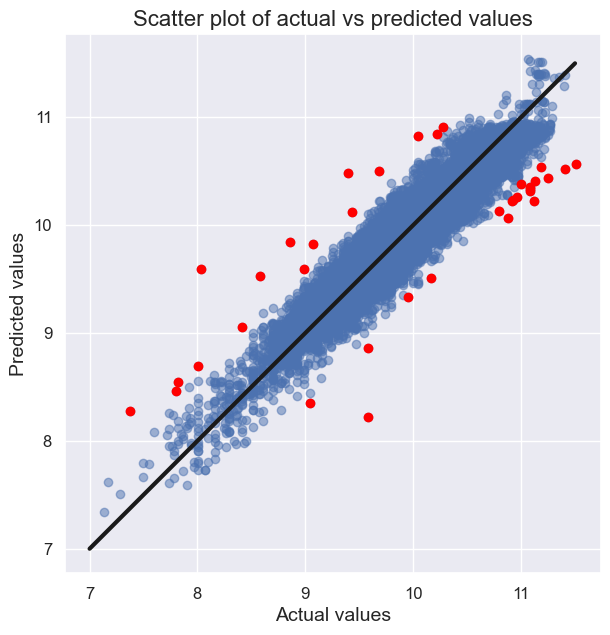

In [42]:
X_vals = pd.concat([X_train, X_test], axis=0).sort_index()
y_vals = pd.concat([y_train, y_test], axis=0).sort_index()

predictions = search_lr. predict(X_vals)
residuals = y_vals-predictions

# calculate absolute residuals
abs_residuals = np.abs(residuals)

# sort absolute residuals in descending order
sorted_abs_residuals = abs_residuals.sort_values(ascending=False)

# calculate IQR
q1, q3 = np.percentile(sorted_abs_residuals, [1,99])
iqr = q3 - q1

# identify threshold for outliers
threshold = 1.5 * iqr

# identify outliers
# outlier_indices = np.where(abs_residuals > threshold)[0]
logic_ind = abs_residuals > threshold

num_ind = (logic_ind[logic_ind==True]).index

plt.figure(figsize=(7,7))
# plot scatter plot with outliers highlighted
plt.scatter(y_vals, predictions, alpha=0.5)
plt.plot([7, 11.5],[7, 11.5], c="k", lw=3)
plt.scatter(y_vals[logic_ind], predictions[logic_ind], color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of actual vs predicted values')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

# map outliers back to original dataset
outliers = data.iloc[num_ind]



In [43]:
outliers_scaled = outliers.copy()
outliers_scaled["price"] = np.exp(outliers_scaled["price"])
outliers_scaled["mileage"] = np.exp(outliers_scaled["mileage"])


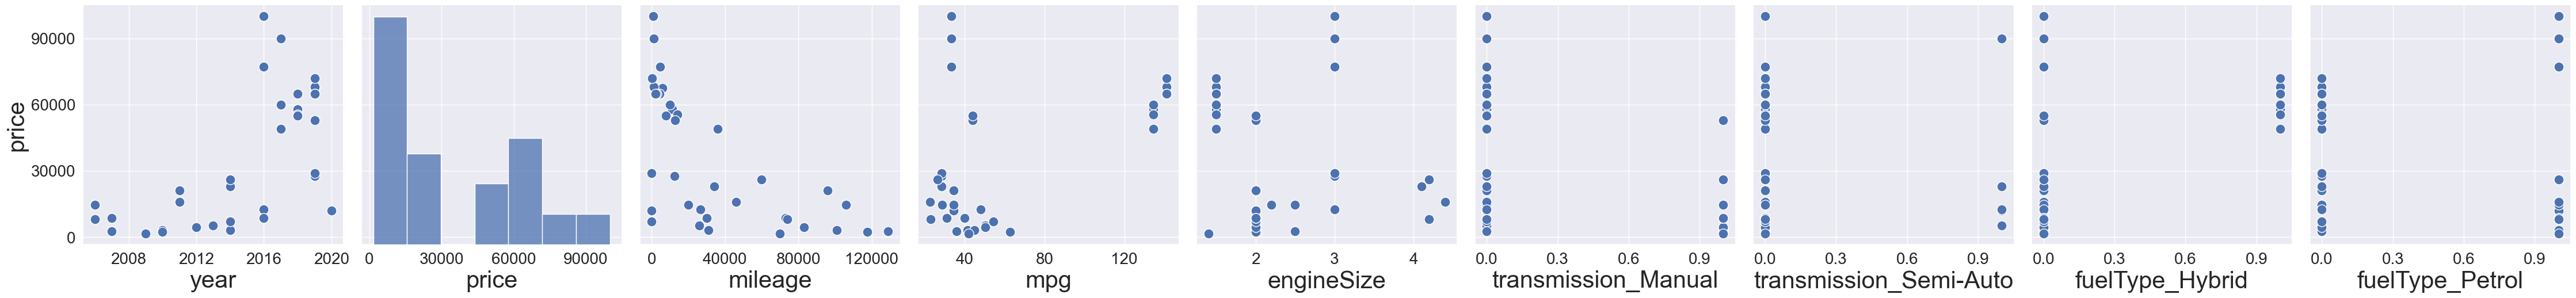

In [44]:

# Initialize a PairGrid
g = sns.PairGrid(
    outliers_scaled,
    y_vars=["price"],
    x_vars=[
        column
        for column in outliers_scaled.columns
        if outliers_scaled[column].dtype != "O"
    ],
    height=5,
)

# Map scatter plot to the PairGrid
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, s=150)

for ax in g.axes.flatten():
    # change font size for x axis
    ax.xaxis.get_label().set_fontsize(30)
    ax.yaxis.get_label().set_fontsize(30)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.tick_params(axis='both', which='major', labelsize=20)

# Linear regression - Difference between brands

In [45]:
data.groupby("brand")["fuelType_Hybrid"].value_counts().unstack()

fuelType_Hybrid,0,1
brand,,
audi,9868,28
bmw,10269,249
vw,11594,142


In [46]:
brands = data["brand"].unique().tolist()

models = {}
models_list = []
X_test_list = []
y_test_list = []


for i, brand in enumerate(brands):
    data_brand = data[data["brand"] == brand]

    X_data_brand = data_brand[FEATURES]
    y_data_brand = data_brand[TARGET]

    X_train_brand, X_test_brand, y_train_brand, y_test_brand = train_test_split(
        X_data_brand,
        y_data_brand,
        test_size=0.25,
        random_state=42,
        stratify=X_data_brand["fuelType_Hybrid"],
    )
    X_test_list.append(X_test_brand)
    y_test_list.append(y_test_brand)

    num_splits = 4
    sk_fold = KFold(n_splits=num_splits, random_state=42, shuffle=True)
    folds = sk_fold.split(X_train_brand, X_train_brand["fuelType_Hybrid"])

    # Define pipeline steps
    steps = [
        ("scaler", MinMaxScaler()),
        ("pol_features", PolynomialFeatures()),
        ("model", LinearRegression()),
    ]

    # Create pipeline object
    pipeline = Pipeline(steps=steps)
    param_grid = {"pol_features__degree": range(1, 6)}

    search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=["neg_root_mean_squared_error", "r2"],
        refit="neg_root_mean_squared_error",
        cv=folds,
        n_jobs=-1,
        verbose=0,
    )

    search.fit(X_train_brand, y_train_brand)

    models[f"{brand}_model"] = search
    models_list.append(search)

/Users/albertovidalrodriguez-bobada/opt/anaconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RMSE of residuals: 0.14
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=42.50, fp-value=0.000
Goldfeld-Quandt test: p-value=0.498, test stat=1.00
----NORMALITY----
Skewness of residuals: -0.39449766291280514
Kurtosis of residuals: 7.315615454034425
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.38
RMSE of residuals: 0.13
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=162.70, fp-value=0.000
Goldfeld-Quandt test: p-value=0.686, test stat=0.97
----NORMALITY----
Skewness of residuals: 0.105361276187836
Kurtosis of residuals: 0.5672327261958947
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.37
RMSE of residuals: 0.13
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=151.64, fp-value=0.000
Goldfeld-Quandt test: p-value=0.131, test stat=1.07
----NORMALITY----
Skewness of residuals: -0.049249085215034835
Kurtosis of residuals: 0.15753711172594898
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.38


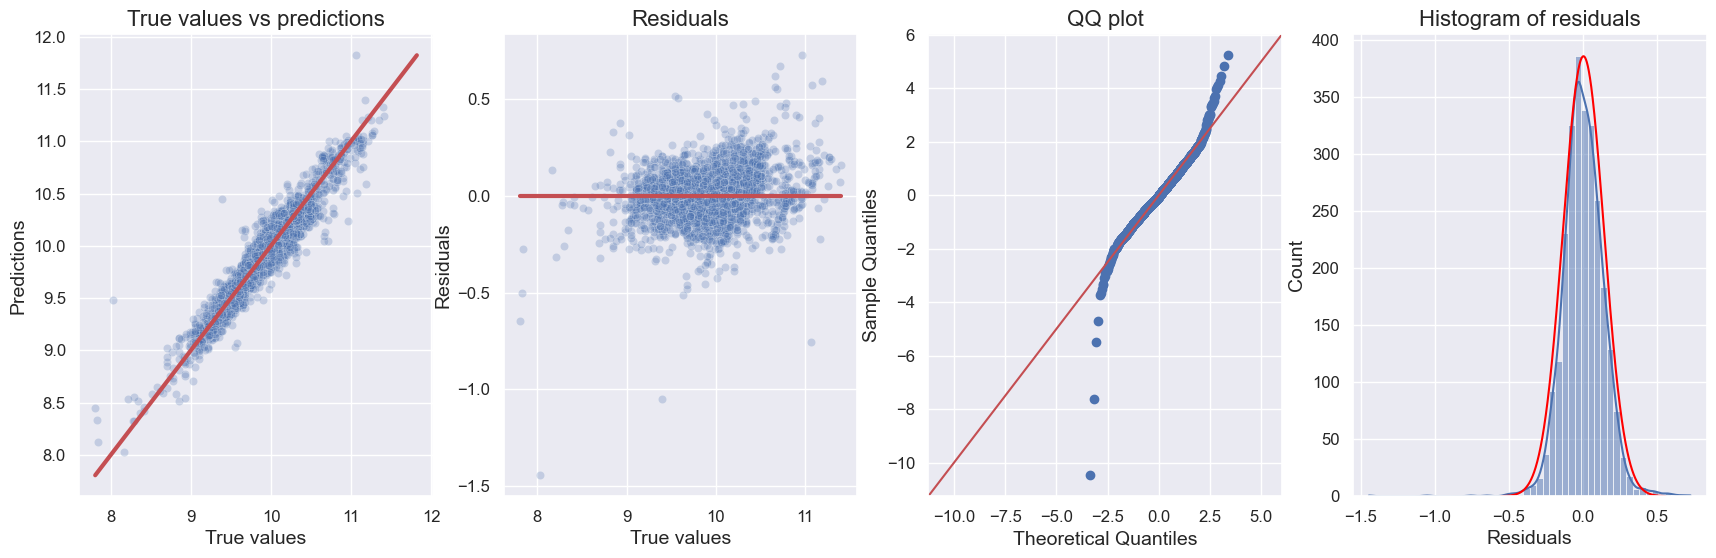

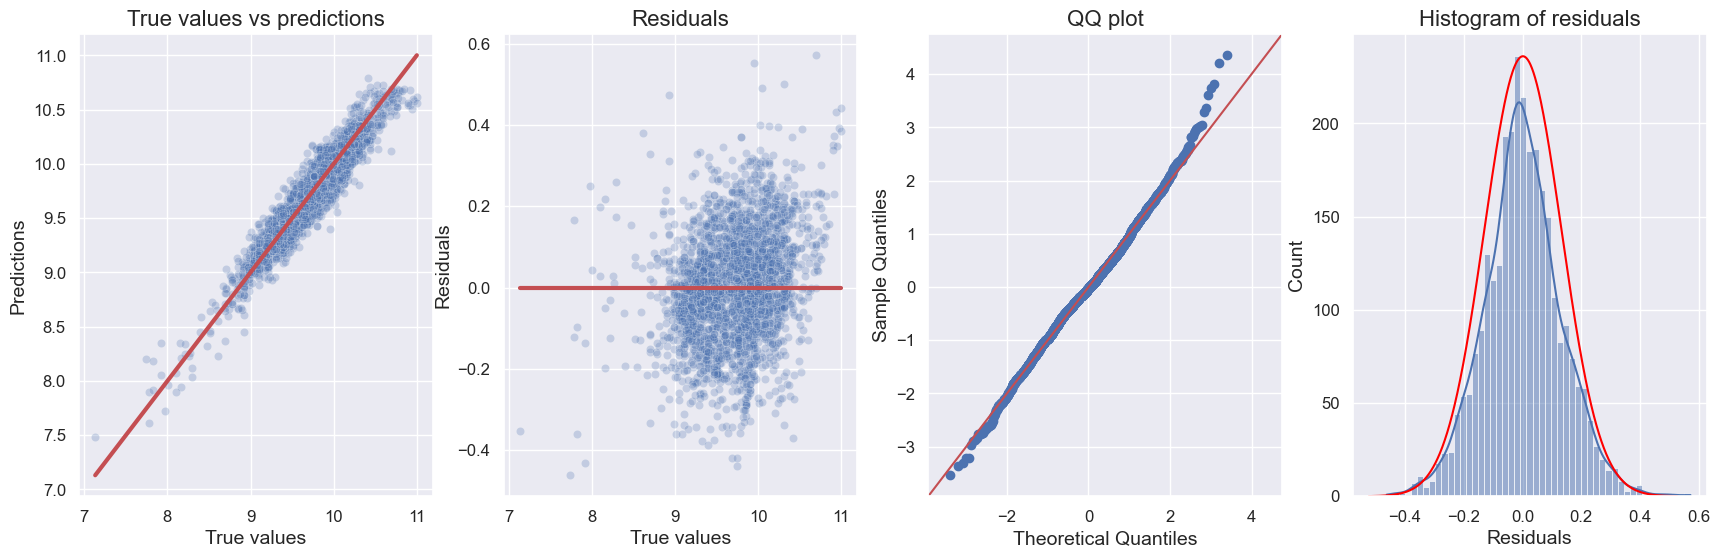

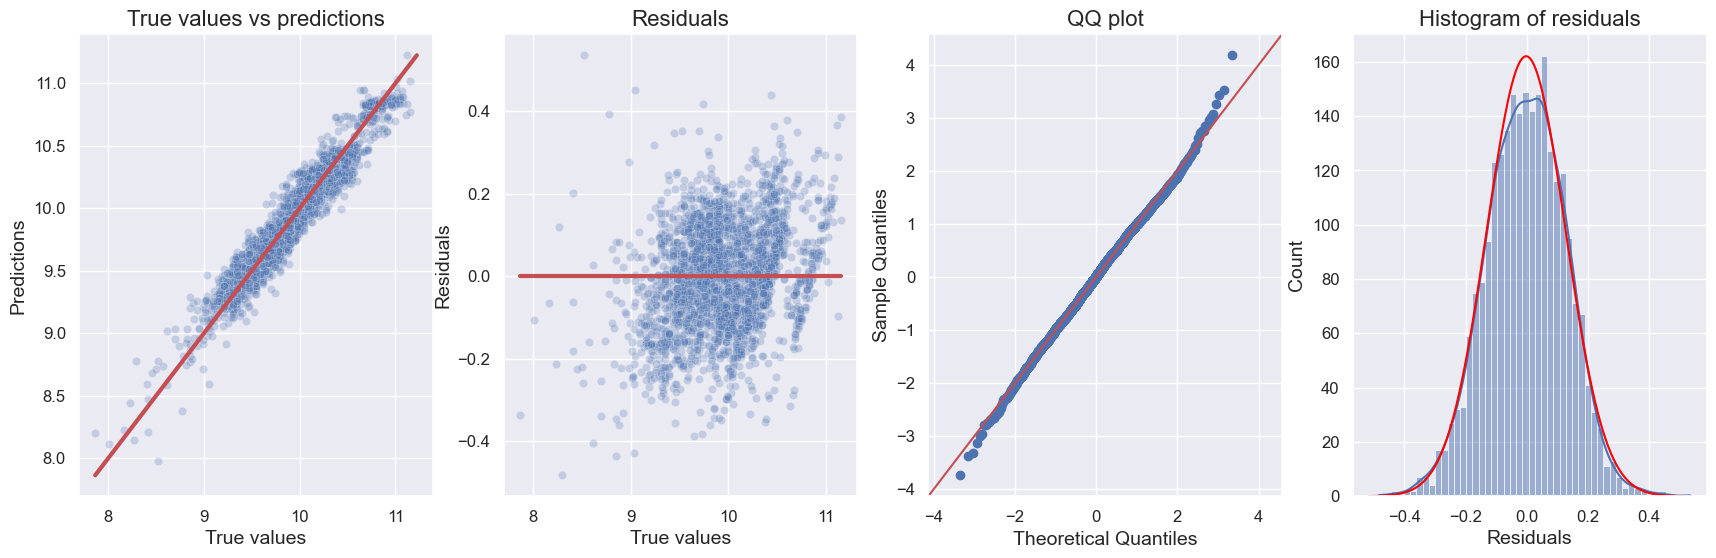

In [47]:
for i, (X_test_brand, y_test_brand, model) in enumerate(zip(X_test_list, y_test_list, models_list)):
    plot_residuals_analysis(X_test_brand, y_test_brand, model)

In [48]:
# Create one hot encoder transformer
transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), ["brand"]),
    remainder="drop",
)

# Transform data and create dataframe with the new data
transformed = transformer.fit_transform(data)
data_transformed = pd.DataFrame(
    transformed, columns=transformer.get_feature_names_out()
)

# Change column types to integer
data_transformed = data_transformed.astype(int)

# Modify new column name to remove "onehotencoder__" from it
new_ohe_col_names = [
    column.replace("onehotencoder__", "")
    for column in transformer.get_feature_names_out().tolist()
]

# Rename columns of the new dataframe
data_transformed.columns = new_ohe_col_names

# Drop original features in the original dataframe and add the one-hot-encoded columns
data_brands = data.copy()
data_brands.drop(["brand"], axis=1, inplace=True)
data_brands = pd.concat([data_brands, data_transformed], axis=1)

data_brands.head()

,model,year,price,mileage,mpg,engineSize,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Petrol,brand_bmw,brand_vw
0,5 Series,2014,9.32,11.11,57.60,2.00,0,0,0,0,1,0
1,6 Series,2018,10.20,9.60,42.80,2.00,0,0,0,1,1,0
2,5 Series,2016,9.68,11.05,51.40,3.00,0,0,0,0,1,0
3,1 Series,2017,9.45,10.19,72.40,1.50,0,0,0,0,1,0
4,7 Series,2014,9.58,10.59,50.40,3.00,0,0,0,0,1,0


In [49]:
FEATURES_BRANDS = [
    column
    for column in data_brands.columns
    if data_brands[column].dtype != "O" and column != TARGET
]


X_data_brands = data_brands[FEATURES_BRANDS]
y_data_brands = data_brands[TARGET]


X_train_brands = X_data_brands.loc[train_idx]
y_train_brands = y_data_brands.loc[train_idx]
X_test_brands = X_data_brands.loc[test_idx]
y_test_brands = y_data_brands.loc[test_idx]

RMSE of residuals: 0.13
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=168.66, fp-value=0.000
Goldfeld-Quandt test: p-value=0.430, test stat=1.01
----NORMALITY----
Skewness of residuals: 0.07758772826584158
Kurtosis of residuals: 3.3233958604193647
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.37


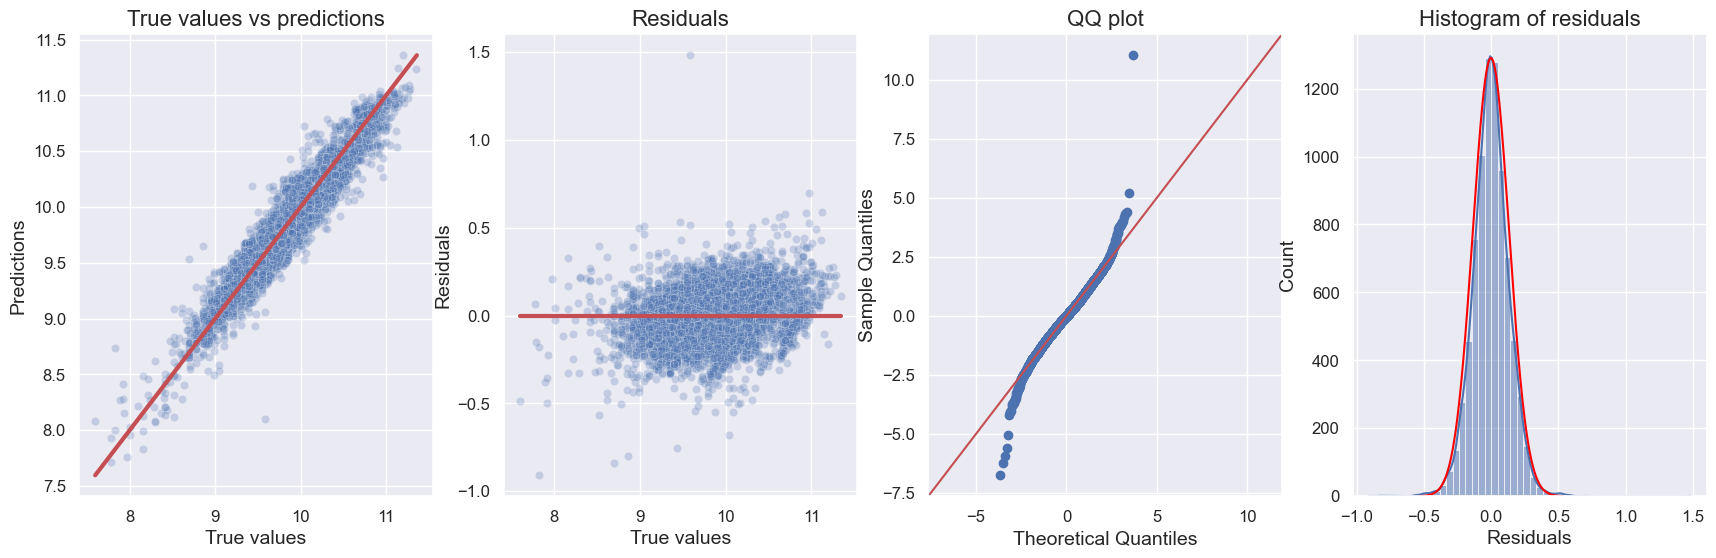

In [50]:
num_splits = 5
sk_fold = StratifiedKFold(n_splits=num_splits, random_state=42, shuffle=True)
folds = sk_fold.split(X_train_brands, X_train_brands["fuelType_Hybrid"])

# Define pipeline steps
steps = [
    ("scaler", MinMaxScaler()),
    ("pol_features", PolynomialFeatures()),
    ("model", LinearRegression()),
]

# Create pipeline object
pipeline = Pipeline(steps=steps)

param_grid = {"pol_features__degree": range(1, 6)}

search_lr_brands = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=["neg_root_mean_squared_error", "r2"],
    refit="neg_root_mean_squared_error",
    cv=folds,
    n_jobs=-1,
    verbose=0,
)

search_lr_brands.fit(X_train_brands, y_train_brands);

plot_residuals_analysis(X_test_brands, y_test_brands, search_lr_brands)

In [51]:
r2_test_brands = r2_score(y_test_brands, search_lr_brands.predict(X_test_brands))
r2_test = r2_score(y_test, search_lr.predict(X_test))

print(f"R2 score of predictions vs true values (test data) for one-hot-encoded brands is {r2_test_brands:.3f}")
print(f"R2 score of predictions vs true values (test data) for no brand difference is {r2_test:.3f}")

R2 score of predictions vs true values (test data) for one-hot-encoded brands is 0.919
R2 score of predictions vs true values (test data) for no brand difference is 0.899


In [52]:
X_vals_brands = pd.concat([X_train_brands, X_test_brands], axis=0).sort_index()
y_vals_brands = pd.concat([y_train_brands, y_test_brands], axis=0).sort_index()

r2_brands_all = r2_score(y_vals_brands, search_lr_brands.predict(X_vals_brands))
r2_all = r2_score(y_vals, search_lr.predict(X_vals))

print(f"R2 score of predictions vs true values (train and test data) for one-hot-encoded brands is {r2_brands_all:.3f}")
print(f"R2 score of predictions vs true values (train and test data) for no brand difference is {r2_all:.3f}")

R2 score of predictions vs true values (train and test data) for one-hot-encoded brands is 0.920
R2 score of predictions vs true values (train and test data) for no brand difference is 0.897


In light of these results, the model in which the brands are encoded leads to the best results and it will be deployed.

In [53]:
# dump(search_lr_brands.best_estimator_, os.getcwd() + "/model/car-price-v1.joblib")

In [54]:
model_v1 = load(os.getcwd() + "/model/car-price-v1.joblib")
model_v1.predict(np.array(X_train_brands.iloc[0]).reshape(1,-1))

array([7.86158029e+14])